In [1]:
! pip install graphiti-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 2.9 MB/s eta 0:00:00
  Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Using cached neo4j-5.28.1-py3-none-any.whl (312 kB)
  Using cached numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
  Using cached openai-1.65.2-py3-none-any.whl (473 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl (431 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
  Using cached anyio-4.8.0-py3-none-any.whl (96 kB)
  Using cached distro-1.9.0-py3-none-any.whl (20 kB)
  Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
  Using cached jiter-0.8.2-cp311-cp311-macosx_11_0_arm64.whl (311 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
  Using cached pydantic_core-2.27.2-cp311-cp311-macosx_11_0_

In [29]:
%load_ext autoreload
%autoreload 2

 
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the datasets

In [1]:
import pandas as pd

llms_history = pd.read_excel("../datasets/llms_history_and_openai_posts//llms_history.xlsx")
df_openai = pd.read_excel("../datasets/llms_history_and_openai_posts/openai_tweets.xlsx")

df_news = pd.read_excel("../datasets/news/df_news_all_llms_eval.xlsx")
df_abstracts = pd.read_excel("../datasets/abstracts/df_abstracts_all_llms_eval.xlsx")

In [32]:
import ast 

def to_dictionary(df): 

    if isinstance(df['factoids'][0], str):
        df["factoids"] = df["factoids"].apply(lambda x:ast.literal_eval(x))
    grouped_df = df.groupby("observation date")["factoids"].sum().reset_index()
    return {
        str(date): factoids for date, factoids in grouped_df.set_index("observation date")["factoids"].to_dict().items()
        }

In [34]:
llms_history_dict = to_dictionary(llms_history)

In [35]:
llms_history_dict

{'30-12-2017': ['Google researchers introduced the Transformer architecture on June 12, 2017.',
  "The paper 'Attention Is All You Need' was released on June 12, 2017.",
  'The Transformer architecture revolutionized natural language processing on June 12, 2017.',
  'The Transformer architecture enables models to process data more efficiently through self-attention mechanisms.'],
 '30-12-2018': ['OpenAI released GPT-1 on June 11, 2018.',
  'GPT-1 is the first Generative Pre-trained Transformer model.',
  'GPT-1 demonstrated the effectiveness of unsupervised pre-training for language understanding tasks.',
  'Google introduced BERT on October 11, 2018.',
  'BERT stands for Bidirectional Encoder Representations from Transformers.',
  'BERT is a transformer-based model.',
  'BERT achieved state-of-the-art results on various NLP benchmarks.',
  'BERT understands context from both directions.'],
 '30-12-2019': ['OpenAI announced GPT-2 on February 14, 2019.',
  'GPT-2 is a significantly larg

In [14]:
import ast
from itertools import chain

factoids = list(chain(*[ast.literal_eval(fact) for fact in df_news["factoids_ground_truth"]]))

In [36]:
from graphiti_core import Graphiti
from graphiti_core.nodes import EpisodeType
from datetime import datetime, timezone
from graphiti_core.llm_client import OpenAIClient, LLMConfig
import os
from graphiti_core.utils.bulk_utils import RawEpisode

os.environ["OPENAI_API_KEY"] = "##"

llm_client = OpenAIClient()

graphiti = Graphiti(uri="bolt://localhost:7687", user = "neo4j", password="##", llm_client=llm_client)

# Construct the graph

In [38]:
from datetime import datetime
import time
import pandas as pd
import dateparser

async def add_episodes(reference_date, episodes):
    for i, factoid in enumerate(episodes):
        await graphiti.add_episode(
        name=f"factoid_{i}",
        episode_body=factoid,
        source=EpisodeType.text,
        # A description of the source (e.g., "podcast", "news article")
        source_description="Technology magazine article",
        # The timestamp for when this episode occurred or was created
        reference_time=dateparser.parse(reference_date),
)

In [42]:
await add_episodes(reference_date='30-12-2020', episodes=llms_history_dict['30-12-2020'])

# Calculate latency

In [16]:
from datetime import datetime
import time
import pandas as pd

async def add_episodes(episodes):
    for i, factoid in enumerate(episodes):
        await graphiti.add_episode(
        name=f"factoid_{i}",
        episode_body=factoid,
        source=EpisodeType.text,
        # A description of the source (e.g., "podcast", "news article")
        source_description="Technology magazine article",
        # The timestamp for when this episode occurred or was created
        reference_time=datetime(2023, 11, 15, 9, 30),
)
async def calculate_latency(factoids: list[str]):
    results = []
    for i in range(1, len(factoids), 20):
        try:
            start = time.perf_counter()
            await add_episodes(episodes=factoids[:i])
            end = time.perf_counter()
            elapsed_time = end - start
            results.append({"number of factoids": i, "graphiti's execution time": elapsed_time})
        except Exception as e:
            # Retry once after error
            print(f"Error processing {i} factoids on first attempt: {e}. Retrying...")
            try:
                start = time.perf_counter()
                await add_episodes(episodes=factoids[:i])
                end = time.perf_counter()
                elapsed_time = end - start
                results.append({"number of factoids": i, "graphiti's execution time": elapsed_time})
            except Exception as e_retry:
                # If retry fails, log the error and continue
                print(f"Error processing {i} factoids on retry: {e_retry}. Skipping...")
                results.append({"number of factoids": i, "graphiti's execution time": None, "error": str(e_retry)})
        finally:
            # Save progress after each iteration
            pd.DataFrame(results).to_excel("scalability_graphiti.xlsx", index=False)
    return pd.DataFrame(results)

In [17]:
await calculate_latency(factoids=factoids)

Retrying after application error (attempt 1/2): Output length exceeded max tokens 2048: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=4, prompt_tokens=672, total_tokens=676, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))


CancelledError: 

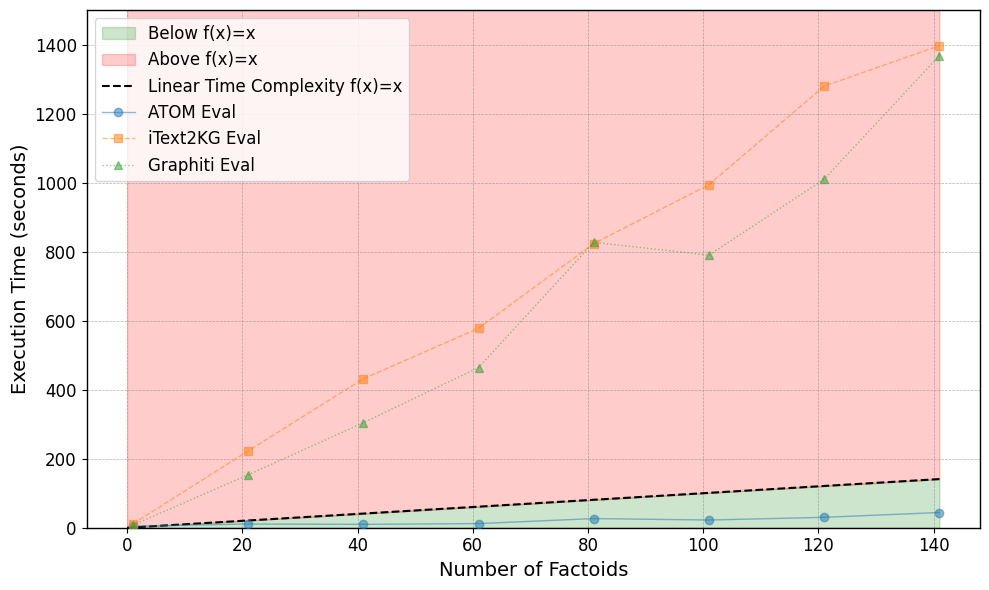

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from Excel files
atom_eval = pd.read_excel("scalability_atom.xlsx")
itext2kg_eval = pd.read_excel("scalability_itext2kg.xlsx")
graphiti_eval = pd.read_excel("scalability_graphiti.xlsx")

# Use only the first 8 rows from each DataFrame
atom_subset = atom_eval.iloc[:8]
itext2kg_subset = itext2kg_eval.iloc[:8]
graphiti_subset = graphiti_eval.iloc[:8]

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Set explicit y-axis limits for consistency
plt.ylim(0, 1500)

# Define the x-range based on the number of factoids (assuming the max is similar across datasets)
x_min = 0
x_max = atom_subset['number of factoids'].max()  # e.g. 141
x_range = np.linspace(x_min, x_max, 200)
y_linear = x_range  # f(x)= x

# Fill regions relative to the linear reference:
# - Below f(x)=x: from f(x)=x down to y=0 (green)
plt.fill_between(x_range, y_linear, 0, color='green', alpha=0.2, label="Below f(x)=x", zorder=0)
# - Above f(x)=x: from f(x)=x up to y=1500 (red)
plt.fill_between(x_range, y_linear, 1500, color='red', alpha=0.2, label="Above f(x)=x", zorder=0)

# Plot the linear reference line f(x)=x
plt.plot(x_range, y_linear, label="Linear Time Complexity f(x)=x", color='black', linestyle='--', zorder=2)

# Plot each method with consistent styling (with a higher zorder to be drawn on top)
plt.plot(atom_subset['number of factoids'],
         atom_subset["atom's execution time"],
         label="ATOM Eval",
         linewidth=1,
         marker='o',
         alpha=0.5,
         zorder=3)

plt.plot(itext2kg_subset['number of factoids'],
         itext2kg_subset["itext2kg's execution time"],
         label="iText2KG Eval",
         linewidth=1,
         linestyle="dashed",
         marker='s',
         alpha=0.5,
         zorder=3)

plt.plot(graphiti_subset['number of factoids'],
         graphiti_subset["graphiti's execution time"],
         label="Graphiti Eval",
         linewidth=1,
         linestyle="dotted",
         marker='^',
         alpha=0.5,
         zorder=3)

# Set axis labels
plt.xlabel('Number of Factoids', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)

# Customize tick font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Enable grid and ensure it is drawn below other elements
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(True, which='both', linestyle="--", linewidth=0.5, color='gray', alpha=0.6)

# Add a scientific border by customizing the axis spines
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Add legend and adjust layout
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Save and show the plot
plt.savefig("latency_comparison_with_linear.pdf")
plt.show()
